    Web Scraping IMDB Top 250
    Gabriel Yohe
    gjy7kb 
    
    Resources used:
    https://www.crummy.com/software/BeautifulSoup/bs4/doc/
    https://www.youtube.com/watch?v=XQgXKtPSzUI&t=633s
    https://pypi.org/project/beautifulsoup4/
    https://programminghistorian.org/en/lessons/intro-to-beautiful-soup
    

The Purpose of this webscrape is to:

1. Learn how to extract data from html
2. See if there is any correlation between the number of reviews a movie receives and its ranking
3. Find any other interesting information related to IMDBs top 250

Organized:

1. Importing and Cleaning
2. Scraping and Organizing HTML
3. Linear Regression
4. Other Analysis
5. Conclusion

A few notes to begin. I first attempted to scape Zillow for housing information but ran into anti webscraping techniques that were above my paygrade. How do I confirm im human if I'm webscraping? I read about some ways but it seemed like quite the rabbit hole. I decided instead to scrape IMDB's top 250 movies and whatever information I could grab from that page. I would have liked to scrape each of movies individual pages but alas, time has not permitted. I had a hunch that the number of ratings a movie received would be correlated with its rating. So I wanted to see if this was true or not. 

# Importing and Reading

I used requests to grab my url and then BeautifulSoup to read its soupyness. I had to use two URLs. One is a url for the page ranked from best movie to worst, and url2 is for the page ranked by number of reviews. I had to do this becuase there is no value for number of reviews, only an ordered list which I have to count. 

In [205]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Mon Jul 20 13:14:01 2020

@author: gabrielyohe

Web Scraping IMDB's top 250 Movies
"""

import csv
from bs4 import BeautifulSoup 
import requests
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

# A URL to imdb's top 250 movies
url = 'https://www.imdb.com/chart/top/?ref_=nv_mv_250'

# A value for the number of ratings a certian movie gets cannot be found on this page.
# Instead, I choose to use the index values the page gives me when ranked by the number of ratings.
# I want to use this index value becuase i think there is a correlation
# between number of ratings and the rating itself. 
#Url2 is the link to the ranked by number or ratings 
url2 = 'https://www.imdb.com/chart/top/?sort=nv,desc&mode=simple&page=1'

# Use Requests to get the url
r = requests.get(url)
r2 = requests.get(url2)

# use beautiful soup to read through the data and save it
soup = BeautifulSoup(r.content, features = 'html.parser')
soup2 = BeautifulSoup(r2.content, features = 'html.parser')

# Scraping and Organizing HTML

So begins the mess. The only two difficult work-arounds were grabbing the index values from the html and adding them to a new list. I also make sure that my DataFrame is full of the correct types. Lastly I wondered if the length of the movie title could effect how much people like it. My hope is that length will not effect the rating. And yes, "Dr. Strangelove or: How I Learned to Stop Worrying and Love the Bomb" will definitely be an outlier. 

In [206]:
#use page soup to find and store the location of what im looking for 
top_list = soup.find('tbody', class_= 'lister-list')

#for amount of user ratings
top_list2 = soup2.find('tbody', class_= 'lister-list')

#the data im interested is each under a tr class
movies = top_list.findAll('tr')
movies2 = top_list2.findAll('tr')
## if there are any issues, its easier to debug outside of the for loop

        #title = movies[0].findAll('td')[1].a.text
        #rating = movies[0].findAll('td')[2].strong.text
        #year = movies[0].findAll('td')[1].span.text.strip('()')

#Initiate Length of loop with length of movies and initiate lists
length = len(movies)
g = []    #List for Data frame with title, rating, and year
g2 = []   # list for number of reviews per movie Rank
indexValue = [] #List for number of movies per movie Index Value

for i in range(0,length):
    each = [movies[i].findAll('td')[1].a.text,
            movies[i].findAll('td')[2].strong.text,
            movies[i].findAll('td')[1].span.text.strip('()')]
    g.append(each)
yo = pd.DataFrame(g, columns =['Title', 'Rating', 'Year']) # yo because thats my name


# We make a list to find the ranking of each movie with regards to 
# number of ratings
# I dont think this can be done in a non iterative way since it 
# is based on index value not the number of ratings directly


for i in range(0,length):
    each1 = [movies2[i].findAll('td')[1].a.text]
    g2.append(each1)

# We have to create a loop that assigns the index values of g2 associated
# with each movie to the movies in yo.
# We attatch each title in the original list to its index value
# in the rating volume ranked list. 
# This is not very cost effective. And there are more efficient ways to do this
# say if your list was bigger or if you just want better run time. 
    

for i in range(0, length):
    for j in range(0, length):
        if [yo.iloc[i]['Title']] == g2[j]:
            indexValue.append(j+1)


# meh why not see if the length of the title effects things
titleLen = []
for i in range(0, length):
    titleLenstr = str(yo.iloc[i]['Title'])
    titleLen.append(len(titleLenstr.replace(' ', '')))

### Adding to Pandas Dataframe with Proper Type

In [207]:
#add Number of Reviews ranking to Data frame as new column
yo['Number of Reviews Ranking'] = indexValue

#Create a column for rank
yo['Rank'] = range(1,251)

#Create Column for Year and convert to integer
yo['Year'] = yo['Year'].astype(int)

#Create Column for Rating and convert to float
yo['Rating'] = yo['Rating'].astype(float)

# Add title length list to pandas data frame
yo['Title Length'] = titleLen

### CSV in Own Cell for Bugging

In [208]:
# Create pretty csv with our badass data
yo.to_csv('/Users/gabrielyohe/DataScience/Homework/HomeworkCS/Module4/top250.csv')

# Linear Regression

So here we attempt to answer if there is a relationship between Number of Reviews a movie receives and its rank. I'll explain this as we go along the gravy train. The first plot is simply the rank of the rating of each movie by the rank of the number of reviews each movie recieves. This graph is not the most accurate representation of the correlation because the actual difference of ratings between movies is not a constant increment. Unfortunately, IMDB rounds off each rating to one decimal place, so it can be difficult to understand the true difference between ratings. This can be seen in FIGURE 2. 

FIGURE 1


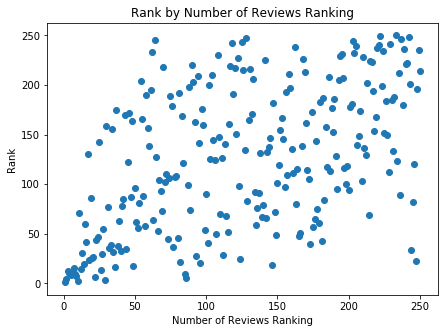

In [209]:
plt.scatter(yo['Number of Reviews Ranking'],yo['Rank'])
plt.xlabel('Number of Reviews Ranking')
plt.ylabel('Rank')
plt.title('Rank by Number of Reviews Ranking')
print('FIGURE 1')

Our scatter plot above shows what appears to be a loose correlation of Number of Reviews and Rank. So we try plotting by rating instead of rank. FIGURE 2 shows more accurately the difficulty of getting above an 8.8. We can also see if you have a rating above an 8.7, your chances of having a ton of reviews grows higher. 

FIGURE 2


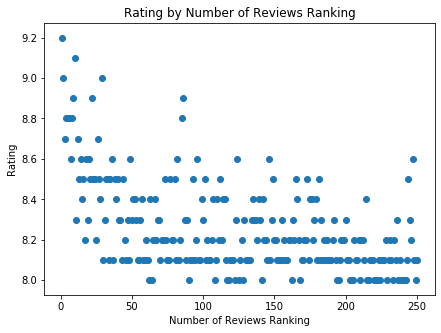

In [210]:
plt.scatter(yo['Number of Reviews Ranking'],yo['Rating'])
plt.xlabel('Number of Reviews Ranking')
plt.ylabel('Rating')
plt.title('Rating by Number of Reviews Ranking')
print('FIGURE 2')

Our Coefficients are about what we would imagine them to be. Our R^2 values are low, and I wouldn't want to use this information pratically. But there does appear to be a linear correlation between our two variables. 

In [211]:
# Convert to np for linear regression analysis
nump= yo.to_numpy()
numpNumReviews = (nump[:,3]).reshape(-1, 1)
numpRank = nump[:,4]
numpRating = nump[:,1]
model = LinearRegression().fit(numpNumReviews, numpRank)
model2 = LinearRegression().fit(numpNumReviews, numpRating)

#Check out the outputs
r_sq = model.score(numpNumReviews, numpRank)
r_sq2 = model2.score(numpNumReviews, numpRating)
ypredict = model.predict(numpNumReviews)
ypredict2 = model2.predict(numpNumReviews)
print('R^2 for model 1 is: ', r_sq)
print('R^2 for model 2 is: ', r_sq2)
print('Intercept for model 1: ', model.intercept_)
print('Slope for model 1: ', model.coef_)
print('Intercept model 2: ', model2.intercept_)
print('Slope for mode 2: ', model2.coef_)


R^2 for model 1 is:  0.26652971155009275
R^2 for model 2 is:  0.28974810396062634
Intercept for model 1:  60.70872289156627
Slope for model 1:  [0.51626516]
Intercept model 2:  8.474101204819277
Slope for mode 2:  [-0.00171555]


FIGURE 3


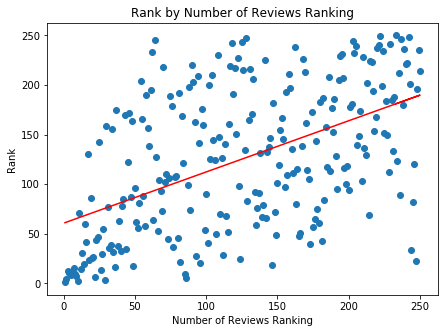

In [212]:
plt.scatter(yo['Number of Reviews Ranking'],yo['Rank'])
plt.xlabel('Number of Reviews Ranking')
plt.ylabel('Rank')
plt.title('Rank by Number of Reviews Ranking')
plt.plot(numpNumReviews, ypredict, color='red')
print('FIGURE 3')

FIGURE 4


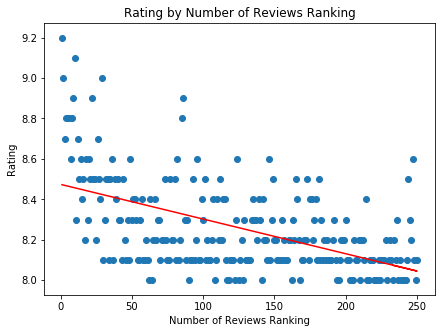

In [213]:
plt.scatter(yo['Number of Reviews Ranking'],yo['Rating'])
plt.xlabel('Number of Reviews Ranking')
plt.ylabel('Rating')
plt.title('Rating by Number of Reviews Ranking')
plt.plot(numpNumReviews, ypredict2, color='red')
print('FIGURE 4')

# Other Analysis

Now, We just explore the data. 

FIGURE 5 shows some more discouraging data on the relationship we are trying to make between Rating and Number of Reviews. This plot shows pretty strong signs of heteroskedasticity. Meaning, there appears to be a strong relationship between the sheer volume of reviews on all movies as time increases. This is not surprising since the human poplulation has gone from 1 bil to 7 bil in 200 years. Yikes. The production of movies also increases over time, meaning, the chances of the highest rating existing in this current time are higher than they were when movies first started being made. This may explain any correlation between number of ratings and rating. FIGURE 6 shows this. 

FIGURE 5


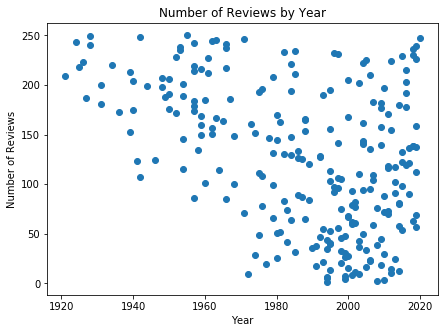

In [214]:
plt.rcParams['figure.figsize'] = [7, 5]
plt.scatter(yo['Year'], yo['Number of Reviews Ranking'])
plt.xlabel('Year')
plt.ylabel('Number of Reviews')
plt.title('Number of Reviews by Year')
print('FIGURE 5')

FIGURE 6


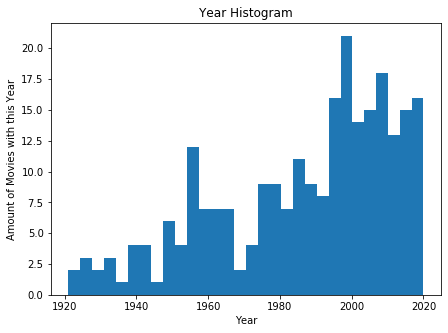

In [215]:
plt.hist(yo['Year'], 30)
plt.xlabel('Year')
plt.ylabel('Amount of Movies with this Year')
plt.title('Year Histogram')
print('FIGURE 6')

FIGURE 7


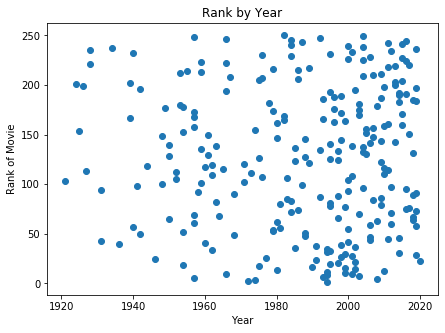

In [216]:
plt.rcParams['figure.figsize'] = [7, 5]
plt.scatter(yo['Year'], yo['Rank'])
plt.xlabel('Year')
plt.ylabel('Rank of Movie')
plt.title('Rank by Year')
print('FIGURE 7')

FIGURE 8


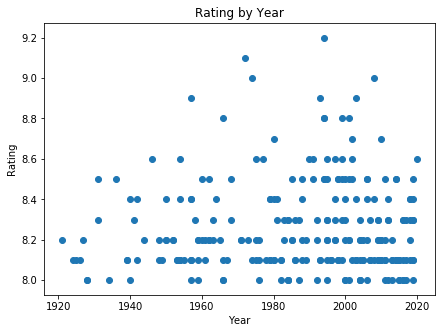

In [217]:
plt.scatter(yo['Year'], yo['Rating'])
plt.xlabel('Year')
plt.ylabel('Rating')
plt.title('Rating by Year')
print('FIGURE 8')

FIGURE 9


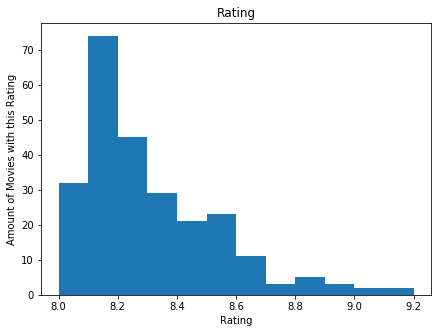

In [218]:
plt.hist(yo['Rating'], 12)
plt.xlabel('Rating')
plt.ylabel('Amount of Movies with this Rating')
plt.title('Rating')
print('FIGURE 9')

FIGURE 10 was mostly for fun. Does the title length correlate to the likability of a movie? The answer, thankfully, is no. I bet, however, we might see some correlations if we included all movies, the good, the bad, and the ugly. But a good movie appears to be a good movie no matter the length of the name. FIGURE 11 is interesting; it appears having 9 to 13 letters in your title is tasteful. 

FIGURE 10


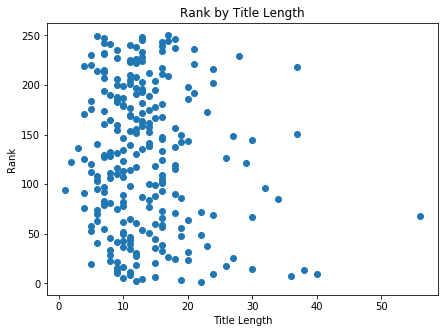

In [219]:
plt.scatter(yo['Title Length'],yo['Rank'])
plt.xlabel('Title Length')
plt.ylabel('Rank')
plt.title('Rank by Title Length')
print('FIGURE 10')

FIGURE 11


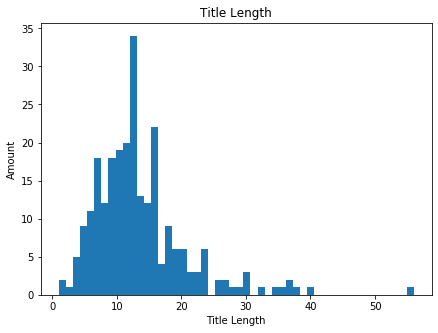

In [220]:
plt.hist(yo['Title Length'], 50)
plt.xlabel('Title Length')
plt.ylabel('Amount')
plt.title('Title Length')
print('FIGURE 11')

# Conclusion

Web Scraping is hard for a noob like me. Unfortunately or fortunately, we cannot conclude that the number of reviews, when controlling for population, has much of any correlation to the rating a movie receives. (Ideally, we would have done some hypothesis testing) That being said, it is interesting that the better movies dont automatically receive more reviews. This suggests that views are not entirely correlated by how good people thinks a movie is; at least, after its in the top 250 movies of all time. What would be really interesting is to get our hands on the entire imdb database, or at least a healthy random sample of it. In particular, I would want to get my hands on critic reviews and contrast them with user reviews, then graph the differences between those over time. Perhaps this could could be correlated to the difference between the opinion of the elite and the masses over History. 